Downcasting floats.


/home/ncote/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Error: No 2023 stats found for 'Aaron Rodgers'.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2024 Week 1 Prediction for Matthew Stafford:
Team: LA
Position: QB
Predicted passing yards: 281.09
Predicted passing attempts: 37.76
Predicted passing completions: 26.37
Predicted rushing yards: 3.99
Predicted rushing attempts: 1.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2024 Week 1 Prediction for Russell Wilson:
Team: PIT
Position: QB
Predicted passing yards: 243.25
Predicted pas

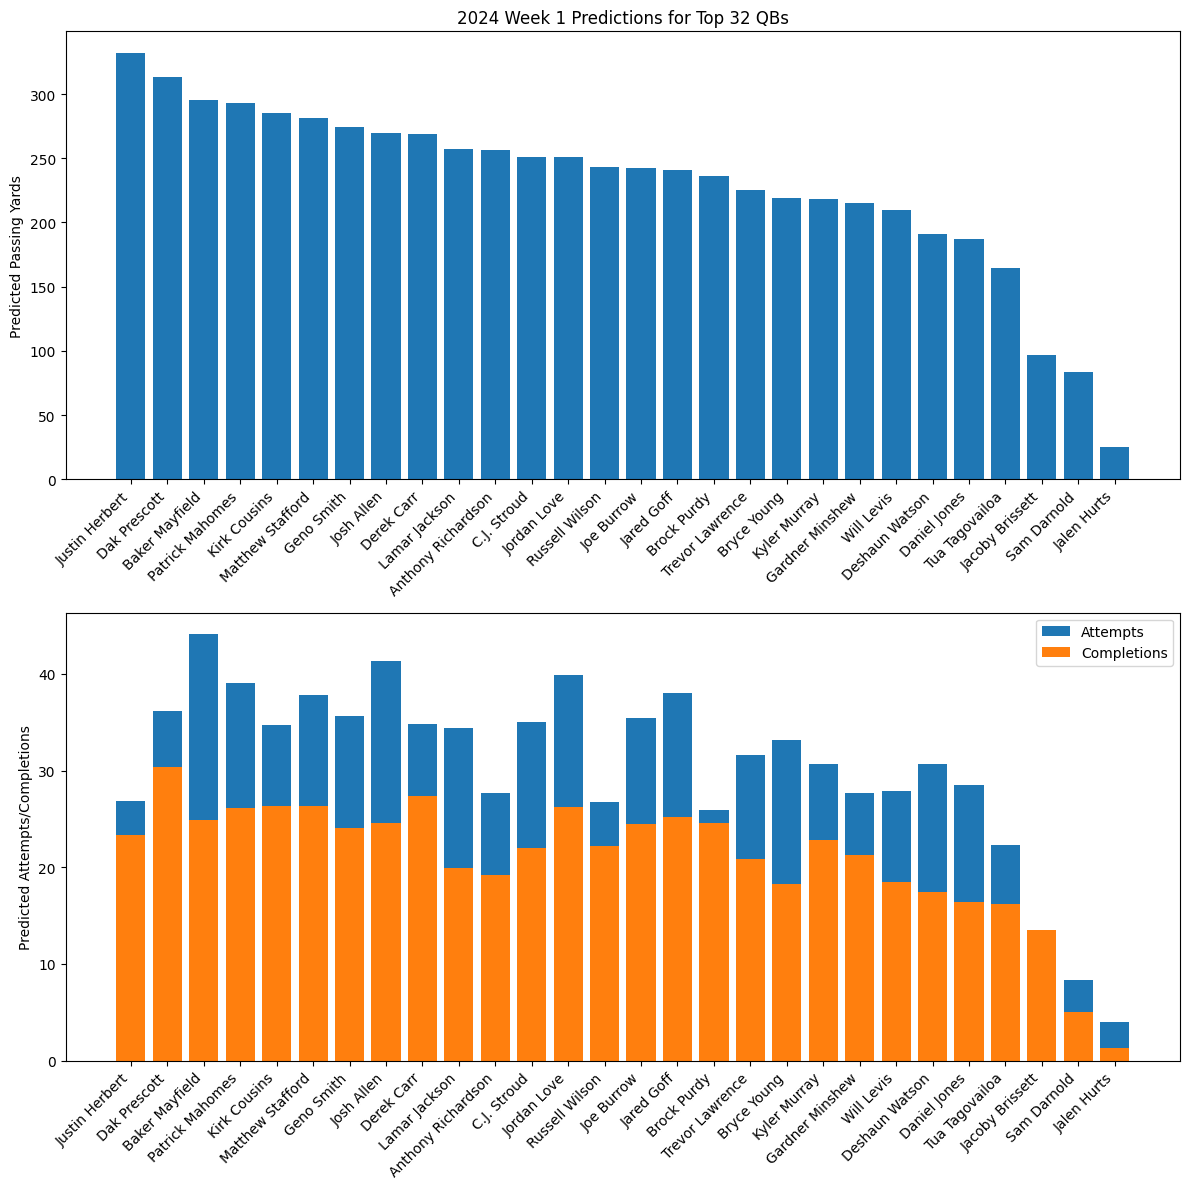

No valid predictions for RB
No valid predictions for WR
No valid predictions for TE


In [6]:
import pandas as pd
import numpy as np
from nfl_data_py import import_weekly_data, import_players, import_rosters, import_schedules
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# 1. Fetch data
seasons = list(range(2018, 2024))  # Adjust the range as needed
player_stats = pd.concat([import_weekly_data(seasons)])
players = import_players()
latest_rosters = import_rosters([2024])  # For 2024 predictions
schedule_2024 = import_schedules([2024])

# 2. Preprocess data
df = pd.merge(player_stats, players, left_on='player_id', right_on='gsis_id', how='left')
df = df.sort_values(['player_id', 'season', 'week'])

# Create target variables
target_cols = ['passing_yards', 'attempts', 'completions', 
               'rushing_yards', 'carries', 
               'receiving_yards', 'targets', 'receptions']

for col in target_cols:
    df[f'next_week_{col}'] = df.groupby(['player_id', 'season'])[col].shift(-1)

# Remove last week of each season for each player
df = df.groupby(['player_id', 'season']).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

# Identify features
categorical_features = ['position_x', 'recent_team']
numerical_features = target_cols

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)
    ])

# Prepare features
X = df[categorical_features + numerical_features]

# Fit preprocessor and transform data
X_transformed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = (numerical_features + 
                 preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())

# 3. Build and train models
input_dim = X_transformed.shape[1]

def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train models for each stat
models = {}
for stat in target_cols:
    y = df[f'next_week_{stat}'].values
    mask = ~np.isnan(y)
    X_stat = X_transformed[mask]
    y_stat = y[mask]
    
    models[stat] = create_model(input_dim)
    models[stat].fit(X_stat, y_stat, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# 4. Prediction function
def predict_2024_week1(player_name):
    try:
        player_matches = latest_rosters[latest_rosters['player_name'].str.contains(player_name, case=False, na=False)]
        
        if player_matches.empty:
            print(f"Error: Player '{player_name}' not found in the latest roster.")
            return None
        
        if len(player_matches) > 1:
            print(f"Multiple matches found for '{player_name}'. Using the first match.")
        
        player_info = player_matches.iloc[0]
        
        player_stats = df[(df['player_id'] == player_info['player_id']) & (df['season'] == 2023)]
        
        if player_stats.empty:
            print(f"Error: No 2023 stats found for '{player_name}'.")
            return None
        
        last_stats = player_stats.sort_values('week').iloc[-1]
        
        input_data = pd.DataFrame({col: [last_stats[col]] for col in numerical_features})
        input_data['position_x'] = [player_info['position']]
        input_data['recent_team'] = [player_info['team']]
        
        input_transformed = preprocessor.transform(input_data)
        
        predictions = {stat: models[stat].predict(input_transformed)[0][0] for stat in target_cols}
        
        print(f"2024 Week 1 Prediction for {player_name}:")
        print(f"Team: {player_info['team']}")
        print(f"Position: {player_info['position']}")
        
        if player_info['position'] in ['QB']:
            print(f"Predicted passing yards: {predictions['passing_yards']:.2f}")
            print(f"Predicted passing attempts: {predictions['attempts']:.2f}")
            print(f"Predicted passing completions: {predictions['completions']:.2f}")
            print(f"Predicted rushing yards: {predictions['rushing_yards']:.2f}")
            print(f"Predicted rushing attempts: {predictions['carries']:.2f}")
        elif player_info['position'] in ['RB']:
            print(f"Predicted rushing yards: {predictions['rushing_yards']:.2f}")
            print(f"Predicted rushing attempts: {predictions['carries']:.2f}")
            print(f"Predicted receiving yards: {predictions['receiving_yards']:.2f}")
            print(f"Predicted targets: {predictions['targets']:.2f}")
            print(f"Predicted receptions: {predictions['receptions']:.2f}")
        elif player_info['position'] in ['WR', 'TE']:
            print(f"Predicted receiving yards: {predictions['receiving_yards']:.2f}")
            print(f"Predicted targets: {predictions['targets']:.2f}")
            print(f"Predicted receptions: {predictions['receptions']:.2f}")
        
        return predictions
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Get the list of starting QBs for week 1
starting_qbs = set(schedule_2024[schedule_2024['week'] == 1]['away_qb_name'].tolist() +
                   schedule_2024[schedule_2024['week'] == 1]['home_qb_name'].tolist())

def get_all_predictions(position):
    predictions = []
    
    if position == 'QB':
        players = latest_rosters[(latest_rosters['position'] == position) & 
                                 (latest_rosters['player_name'].isin(starting_qbs))]
    elif position == 'RB':
        players = latest_rosters[(latest_rosters['position'] == position) & 
                                 (latest_rosters['depth_chart_position'].isin(['1', '2']))]
    elif position == 'WR':
        players = latest_rosters[(latest_rosters['position'] == position) & 
                                 (latest_rosters['depth_chart_position'].isin(['1', '2', '3']))]
    elif position == 'TE':
        players = latest_rosters[(latest_rosters['position'] == position) & 
                                 (latest_rosters['depth_chart_position'].isin(['1', '2']))]
    else:
        players = latest_rosters[latest_rosters['position'] == position]

    for _, player in players.iterrows():
        pred = predict_2024_week1(player['player_name'])
        if pred:
            if position == 'QB':
                predictions.append((player['player_name'], pred['passing_yards'], pred['attempts'], pred['completions']))
            elif position == 'RB':
                predictions.append((player['player_name'], pred['rushing_yards'], pred['carries'], pred['receiving_yards']))
            elif position in ['WR', 'TE']:
                predictions.append((player['player_name'], pred['receiving_yards'], pred['targets'], pred['receptions']))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions

def plot_top_predictions(position, top_n):
    all_predictions = get_all_predictions(position)
    
    if not all_predictions:
        print(f"No valid predictions for {position}")
        return
    
    top_predictions = all_predictions[:top_n]
    
    if position == 'QB':
        names, yards, attempts, completions = zip(*top_predictions)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
        
        ax1.bar(names, yards)
        ax1.set_ylabel('Predicted Passing Yards')
        ax1.set_title(f'2024 Week 1 Predictions for Top {top_n} {position}s')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        ax2.bar(names, attempts, label='Attempts')
        ax2.bar(names, completions, label='Completions')
        ax2.set_ylabel('Predicted Attempts/Completions')
        ax2.legend()
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        
    elif position == 'RB':
        names, rush_yards, carries, rec_yards = zip(*top_predictions)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
        
        ax1.bar(names, rush_yards)
        ax1.set_ylabel('Predicted Rushing Yards')
        ax1.set_title(f'2024 Week 1 Predictions for Top {top_n} {position}s')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        ax2.bar(names, carries, label='Carries')
        ax2.bar(names, rec_yards, label='Receiving Yards')
        ax2.set_ylabel('Predicted Carries/Receiving Yards')
        ax2.legend()
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        
    elif position in ['WR', 'TE']:
        names, rec_yards, targets, receptions = zip(*top_predictions)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
        
        ax1.bar(names, rec_yards)
        ax1.set_ylabel('Predicted Receiving Yards')
        ax1.set_title(f'2024 Week 1 Predictions for Top {top_n} {position}s')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        ax2.bar(names, targets, label='Targets')
        ax2.bar(names, receptions, label='Receptions')
        ax2.set_ylabel('Predicted Targets/Receptions')
        ax2.legend()
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_top_predictions('QB', 32)
plot_top_predictions('RB', 24)
plot_top_predictions('WR', 36)
plot_top_predictions('TE', 12)